<a href="https://colab.research.google.com/github/ThuanNaN/RanSac-FetureMatching/blob/main/RacSac_featureMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TUTORIAL: LOCAL FEATURE BASED VISUAL SEARCH


# Step 1 - Preparation
This step setups a connection between the Colab server to the Google Drive server (authenticated by your Google account). By this way, you can synchronize the computational machine with your personal data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next step, please install OpenCV version 3.4.2.17 (checked, not sure for other even new version)

In [ ]:
!pip install opencv-python==4.5.3.56
!pip install opencv-contrib-python==4.5.3.56

     |████████████████████████████████| 49.9 MB 71.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 56.1 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Test the installation progress is success or not.

In [ ]:
%matplotlib inline
import sys
# Works in command line but for Jupyter including cv2 python env necessary. I guess it's part of python lib hell
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Step 2 - Read and display image

In [ ]:
img1_path = "/content/all_souls_000013.jpg"
img2_path = "/content/oxford_001458.jpg
#img2_path = tutorial_path + 'data/image/cho_ben_thanh_02.png'

dsize = (1200,900)

img1 = cv2.imread(img1_path)
img1 = cv2.resize(img1,dsize)

img2 = cv2.imread(img2_path)
img2 = cv2.resize(img2,dsize)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(25, 50)) # parallel display of images
fig.add_subplot(1,2,1)
plt.imshow(img1)
fig.add_subplot(1,2,2)
plt.imshow(img2)

# Step 3 - Detect and describe SIFT features

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
#img_with_kp = cv2.drawKeypoints(img1,kp1,img_with_kp)

# Step 4 - Match local features using FLANN (Fast Library for Approximate Nearest Neighbor)

In [ ]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)


# Step 5 - Visualize results

2


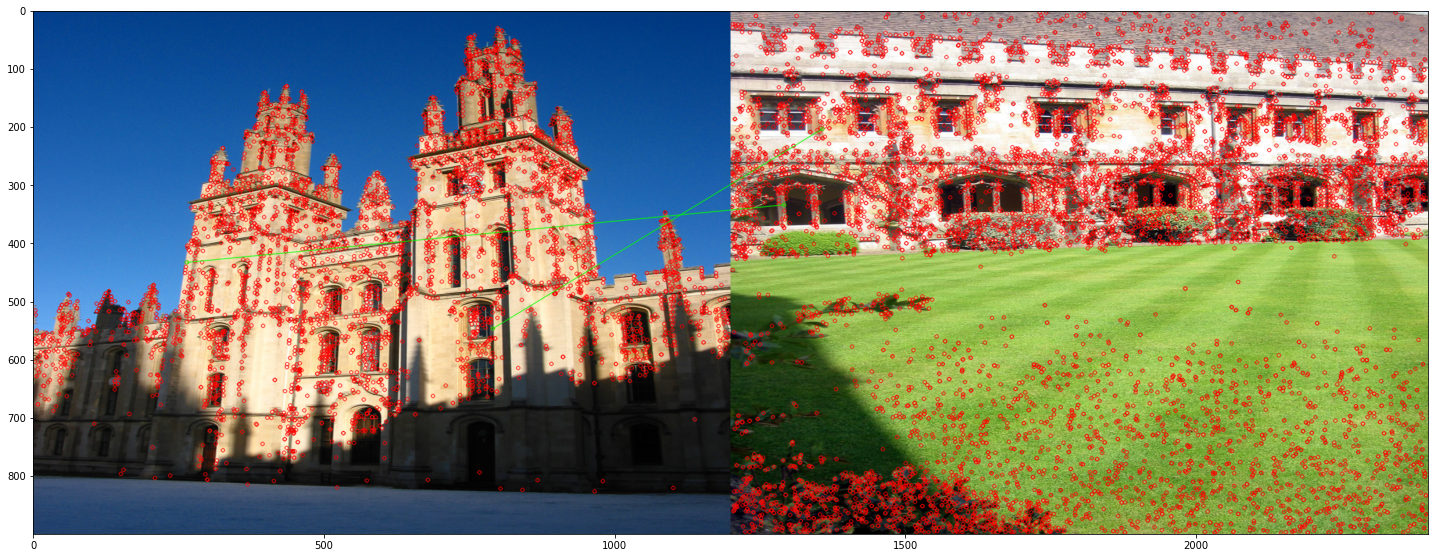

(<matplotlib.image.AxesImage at 0x7f3417946290>, None)

In [ ]:
count_line =0

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        count_line+=1
      
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize=(25, 50))
print(count_line)
plt.imshow(img3,),plt.show()


# cv2.findHomography

Not enough matches are found - 15/20
max matches:  15


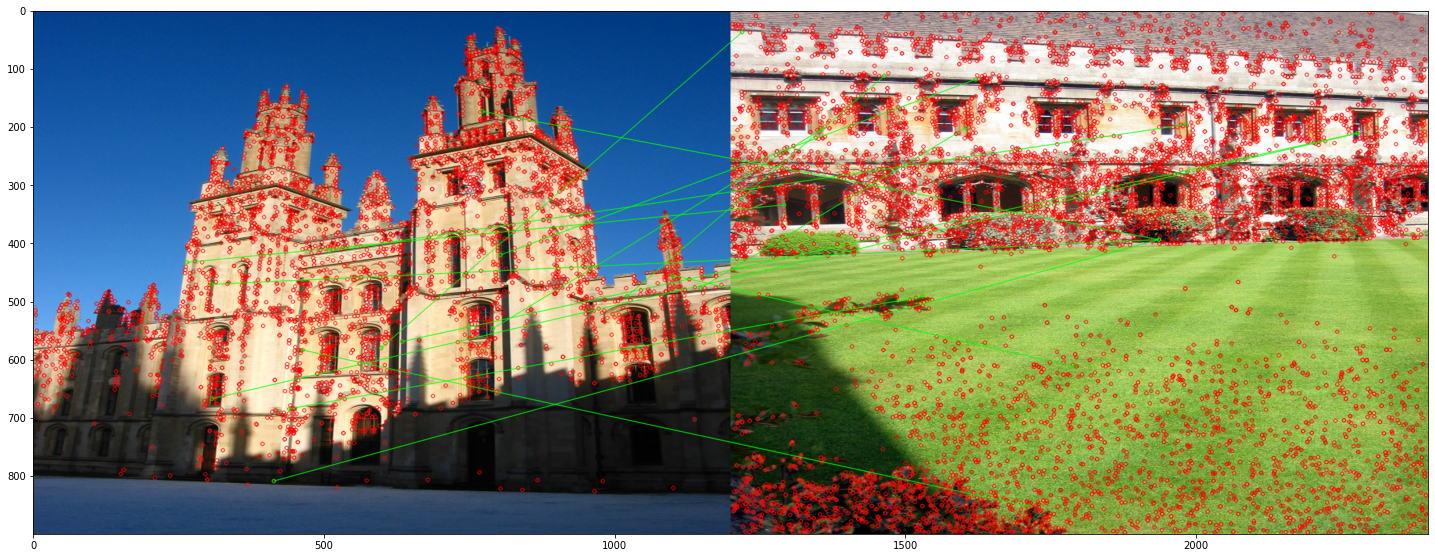

(<matplotlib.image.AxesImage at 0x7f341763d510>, None)

In [ ]:

MIN_MATCH_COUNT= 20
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
     


if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                  singlePointColor = (255,0,0),
                  matchesMask = matchesMask, # draw only inliers
                  flags = cv2.DrawMatchesFlags_DEFAULT)

img4 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)


plt.figure(figsize=(25, 50))
print("max matches: ", len(good))
plt.imshow(img4,),plt.show()
